#               EDA of Jigsaw Unintended Bias in Toxicity Classification

<h1> 1. Business Problem

<h3> 1.1 Description:</h3>
    The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation.
    A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.
    They use data by human raters to improve civility in online conversations for various toxic conversational attributes.
    
   <h3>1.2 Context:</h3>
    This is a Kaggle competetion: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview
    
   <h3>1.3 Data:</h3>
    train.csv, test.csv (Download from Kaggle)
    
   <h3>1.4 Exploratory Data Analysis</h3>

            


In [2]:
#Loading Libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

import contractions

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gc

import os
import re
from tqdm import tqdm


## 1. Load Data

In [3]:
tr_data=pd.read_csv("../Data/train.csv")
test_data=pd.read_csv("../Data/test.csv")

In [4]:
print("Shape of tr_data",tr_data.shape)
print("Shape of test_data",test_data.shape)

tr_data.head()

Shape of tr_data (1804874, 45)
Shape of test_data (97320, 2)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


## 2. Create DataSet with text, aux columns, identity attributes and target

In [51]:
# Create dataset with comment text, target and identity_attributes and drop other columns from train_data
identity_attribute=['male', 'female','homosexual_gay_or_lesbian', 'muslim', 'christian', 'jewish','white', 'black', 'psychiatric_or_mental_illness']


aux_columns = ['target', 'severe_toxicity','obscene','identity_attack','insult','threat','sexual_explicit']
data=tr_data[['comment_text']]
data1=tr_data[identity_attribute]
data2=tr_data[aux_columns]
data=pd.concat([data,data1,data2],axis=1)
data[29:34]

,comment_text,male,female,homosexual_gay_or_lesbian,muslim,christian,jewish,white,black,psychiatric_or_mental_illness,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
29,I applaud Civil's efforts to create some new t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0
30,Why bother writing a review if it's going to b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0
31,Yet call out all Muslims for the acts of a few...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.9125,0.05,0.2375,0.6125,0.8875,0.1125,0.0
32,"I love the idea of upvoting entire articles, t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0
33,Troll free since 2016.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0


In [52]:
x_data = data['comment_text']
y_aux_data = data[aux_columns].fillna(0).values



In [53]:
data

,comment_text,male,female,homosexual_gay_or_lesbian,muslim,christian,jewish,white,black,psychiatric_or_mental_illness,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,"This is so cool. It's like, 'would you want yo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,Thank you!! This would make my life a lot less...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,This is such an urgent design problem; kudos t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,Is this something I'll be able to install on m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,haha you guys are a bunch of losers.,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.893617,0.021277,0.000000,0.021277,0.872340,0.0,0.000000
5,ur a sh*tty comment.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,0.047619,0.638095,0.000000,0.333333,0.0,0.009524
6,hahahahahahahahhha suck it.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.457627,0.050847,0.305085,0.000000,0.254237,0.0,0.220339
7,FFFFUUUUUUUUUUUUUUU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
8,The ranchers seem motivated by mostly by greed...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9,It was a great show. Not a combo I'd of expect...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [54]:
#y_data=np.where(data['target']>= 0.5, 1, 0)
data['target']= (data['target'].values>=0.5).astype(np.int)
data['target'].head()

0    0
1    0
2    0
3    0
4    1
Name: target, dtype: int32

## 3. Exploratory Data Analysis

## 3.1 Calculate percentage of missing data for different attributes

In [60]:
identity_data = tr_data[identity_attribute]
missing_identity_data = identity_data.isnull().sum(axis=0) / identity_data.shape[0]
missing_identity_data = missing_identity_data[missing_identity_data > 0] * 100
missing_identity_data

male                             77.553558
female                           77.553558
homosexual_gay_or_lesbian        77.553558
muslim                           77.553558
christian                        77.553558
jewish                           77.553558
white                            77.553558
black                            77.553558
psychiatric_or_mental_illness    77.553558
dtype: float64

Almost 77.55% of attributes values are missing

## 3.2 Univariate Analysis of data

In [64]:
data.describe()

,male,female,homosexual_gay_or_lesbian,muslim,christian,jewish,white,black,psychiatric_or_mental_illness,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
count,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000,405130.000000,405130.000000,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,0.108687,0.127670,0.025611,0.049460,0.095268,0.017863,0.05695,0.034393,0.012083,7.996902e-02,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,6.605974e-03
std,0.267894,0.305384,0.143739,0.202459,0.256671,0.122145,0.21596,0.167900,0.089183,2.712453e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,4.529782e-02
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000e+00
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## 3.3 Analysis of target variable(output variable)

In [38]:
data['target'].value_counts()

0    1660540
1     144334
Name: target, dtype: int64

In [77]:
data['target'][data['target']==1].count()

144334

In [81]:
toxic_per=(data['target'][data['target']==1].count()*100)/data['target'].shape[0] 
print("Percentage of comments which are toxic: ", toxic_per)
non_toxic_per=(data['target'][data['target']==0].count()*100)/data['target'].shape[0] 
print("Percentage of comments which are non_toxic: ", non_toxic_per)



Percentage of comments which are toxic:  7.9969017227795405
Percentage of comments which are non_toxic:  92.00309827722046


Highly imbalance data: 92% of comments are non-toxic

## Distribution Plot of target values

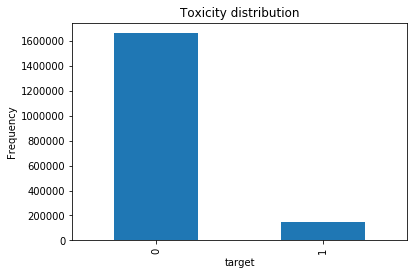

In [40]:
## Distribution of target values
data['target'].value_counts().plot(kind='bar',x='target',y='Value_Counts')
plt.xlabel("target")
plt.ylabel("Frequency")
plt.title('Toxicity distribution')
plt.show()


Highly imbalance data

## 3.4 Aux Data Analysis

In [86]:
labels = ['severe_toxicity','obscene','identity_attack','insult','threat','sexual_explicit']
class_cnt = {}
for label in labels:
    # count number of samples per toxicity type, how many are toxic
    class_cnt[label] = len(data[data[label] == 1])
    
# sort dict from bigger to lower key value
class_cnt = {k: v for k, v in sorted(class_cnt.items(), key = lambda item: item[1], reverse = True)}

In [87]:
class_cnt

{'insult': 3758,
 'identity_attack': 176,
 'obscene': 165,
 'threat': 135,
 'sexual_explicit': 42,
 'severe_toxicity': 1}

Insult is most toxic type comment

In [102]:
total_toxic_count=data['target'][data['target']==1].count()
toxic_insult_per=(data['insult'][data['insult']==1].count()*100)/total_toxic_count
print("Percentage of comments which are toxic because of insult: ", toxic_insult_per)

toxic_ia_per=(data['identity_attack'][data['identity_attack']==1].count()*100)/total_toxic_count
print("Percentage of comments which are toxic because of identity_attack: ", toxic_ia_per)



Percentage of comments which are toxic because of insult:  2.6036831238654785
Percentage of comments which are toxic because of identity_attack:  0.12193939058018208


2.6% of toxic comments are of insult  type 

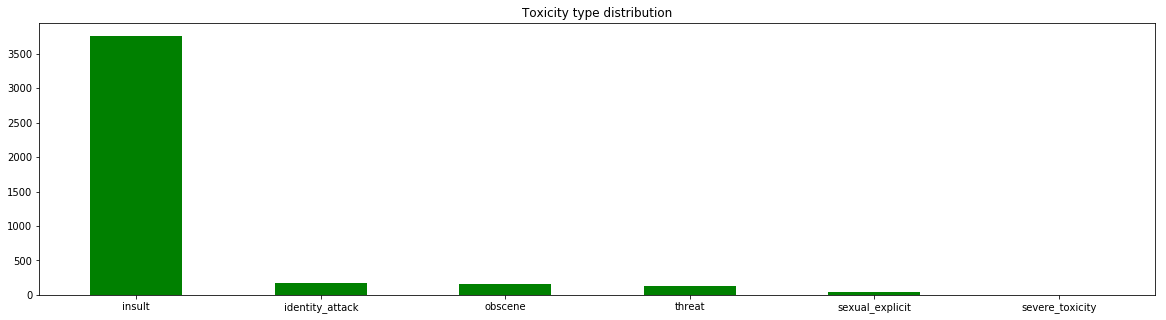

In [104]:
plt.figure(figsize=(20,5))
plt.bar(class_cnt.keys(), class_cnt.values(), color = 'g',width=.5)
plt.title('Toxicity type distribution')

plt.show()

In [96]:
data['insult'].head()

0    0.00000
1    0.00000
2    0.00000
3    0.00000
4    0.87234
Name: insult, dtype: float64

## 3.5 Analysis of text comments

In [114]:
length = x_data.apply(len)
print(x_data.head(),length.head())

0    This is so cool. It's like, 'would you want yo...
1    Thank you!! This would make my life a lot less...
2    This is such an urgent design problem; kudos t...
3    Is this something I'll be able to install on m...
4                 haha you guys are a bunch of losers.
Name: comment_text, dtype: object 0    101
1    114
2     86
3     84
4     36
Name: comment_text, dtype: int64


count    1.804874e+06
mean     2.972343e+02
std      2.691966e+02
min      1.000000e+00
25%      9.400000e+01
50%      2.020000e+02
75%      4.140000e+02
max      1.906000e+03
Name: comment_text, dtype: float64


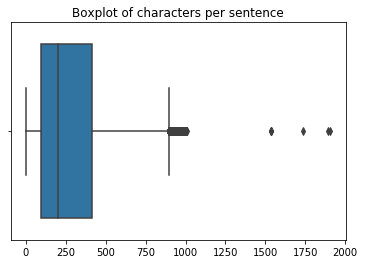

In [115]:
# compute character length of comments
length_df = length.to_frame()
# print basic metrics of length of characters in text comments
print(length.describe())
# Draw box plot of lengths
sns.boxplot(x=length_df)
plt.title('Boxplot of characters per sentence')
plt.show()

Analysis:
- 297 is mean number of characters length of text
- 1 is minimum number of character in a text
- 1906 is maximum number of characters in comment texts

### Calculate IQR of characters of text

In [117]:
Q1, Q3 = length_df.quantile(0.25), length_df.quantile(0.75)
IQR = Q3 - Q1
IQR

comment_text    320.0
dtype: float64

## Distribution plot of number of characters per comment.

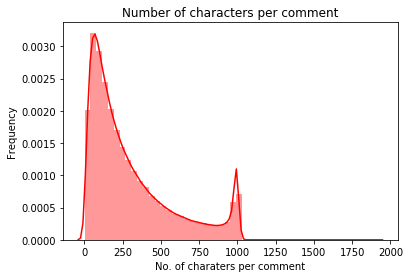

In [118]:
sns.distplot(length_df, color='r')
plt.title('Number of characters per comment')
plt.xlabel("No. of charaters per comment")
plt.ylabel("Frequency")


plt.show()

### As mean value was 297 and max value was 1906, above distribution is justified.
There is a little peak around no of characters =1000

## 3.6 Wordclound to find most repitive words in all aux columns for toxic comments only

In [119]:
from wordcloud import WordCloud
def class_wordcloud(df, label, max_words):
    # data preprocessing: concatenate all reviews for class 1 i.e >0.5 i.e toxic comments
    text = " ".join(x for x in df[df[label]>0.5].comment_text)

    # create and generate a word cloud image
    wordcloud = WordCloud(max_words=max_words, background_color="white", collocations=False).generate(text)

    # display the generated image
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most popular {max_words} words in class {label}")
    plt.show()

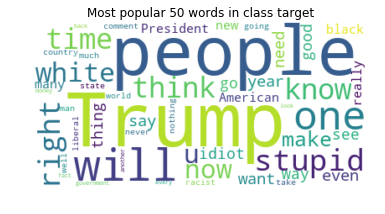

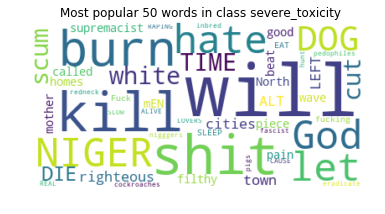

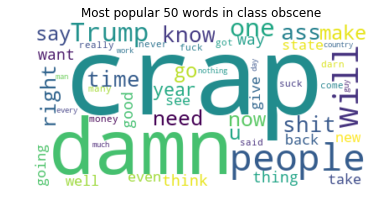

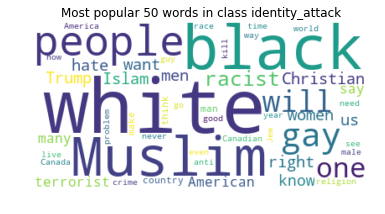

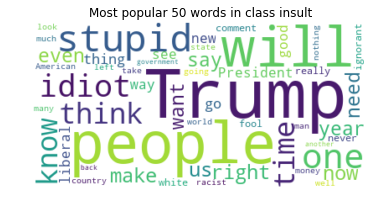

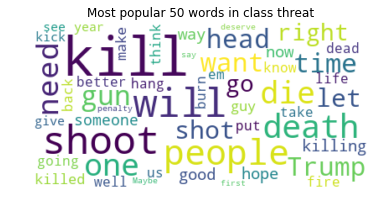

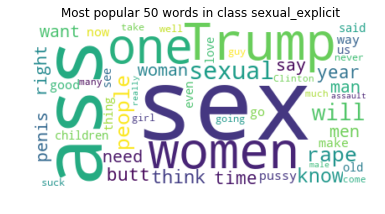

In [120]:
for label in aux_columns:
    class_wordcloud(data, label, 50)

Most frequent word for:
    - target: Trumph, people
    - severe_toxicity: will, kill
    - obscene: crap
    - identity_attack: white, black, muslim
    - insult: Trumph, people
    - threat: kill
    - sexual_explicit: sex,ass
    
 This make sense as well as relatable as per human understanding

## 3.7 Featurization

### 3.7.1: Data Preprocessing

In [134]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

preprocessed_data=[]
stemmer = SnowballStemmer("english")
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() 
for sentance in (x_data.values):
    sentance = re.sub(r"http\S+", "", sentance)  #Removing http/https tag
    sentance = BeautifulSoup(sentance, 'lxml').get_text() # Removing xml tags
    #sentance = decontracted(sentance) # expanded short words like n't to not
    sentance = contractions.fix(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip() # Remove words with numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) # remove special characters
    sentance = stemmer.stem(sentance)
    sentance = lemmatizer.lemmatize(sentance)
    preprocessed_data.append(' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mukesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.....'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'You are absolutely right...\n\n/..'" looks like a filename, not

C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'. . . Exactly.\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Well Said...\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-pac

C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Suppose only the future will tell.\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Interesting though..\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Possibly...\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % m

C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b". . . more 'straw man' tootling..\n\n/.."" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b". . . it's a Liberal thing.\n\n/.."" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Well Said..\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup

C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'. . . generalizing statement over a whole population. Tsk Tsk..\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b"No Rust & Well Constructed  -- That's the Ticket.. !!\n\n/.."" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b"That is simply more manipulative propaganda from an experimental gov't which is strong-arming its people.\n\n/.."" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: Use

C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Well Said, Canadian...!!\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'You have got to be Kidding ?!?\n\n ... Good Try -- No Cigar. \n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Well Done...\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautifu

C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Excellent Comment... Well Said, Teddy.\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Exactly.\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Well Said.\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\mukesh\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'Well Said.\n\n/..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Sou

### 3.7.2 Bag of Words

In [137]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_data)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_data)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaannnnnnnnnnnnnnnnnnnnnnnnnnnnnd', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaggggggghhhh']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1804874, 259418)
the number of unique words  259418


#### lets calculated top 20 frequent words

In [144]:
sum_words = final_counts.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

[('not', 1377987),
 ('would', 364155),
 ('no', 319544),
 ('people', 307208),
 ('one', 268355),
 ('like', 257742),
 ('trump', 241098),
 ('us', 204935),
 ('get', 197851),
 ('time', 160540),
 ('think', 150316),
 ('many', 140609),
 ('know', 139061),
 ('good', 138724),
 ('even', 136943),
 ('right', 135480),
 ('years', 124373),
 ('see', 122560),
 ('could', 120704),
 ('make', 119209)]

We can see word 'trump' and 'people' are there in top frequent words. But 'People' rank higher than 'trump'
Both words appear in word cloud for target values as well

## TF-IDF Featurization

In [155]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tf_idf_vect.fit(preprocessed_data)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_data)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['abandoned', 'abiding', 'ability', 'able', 'aboriginal', 'abortion', 'abortions', 'absolute', 'absolutely', 'absolutely no']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1804874, 5000)
the number of unique words including both unigrams and bigrams  5000


#### Top 20 words acc to tf-idf

In [174]:
sum_words = final_tf_idf.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for idx,word in enumerate(tf_idf_vect.get_feature_names())]
sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]

[('not', 77527.96133961769),
 ('would', 31785.067045168413),
 ('no', 29924.62149606414),
 ('trump', 27432.18563597704),
 ('people', 27255.022348532988),
 ('like', 26390.176518379154),
 ('one', 25599.197631183386),
 ('get', 21465.753332931057),
 ('us', 20507.14945129373),
 ('good', 18218.779798759497),
 ('think', 17727.241141040126),
 ('time', 17676.168567291417),
 ('right', 16953.391028573205),
 ('know', 16924.439456450666),
 ('well', 15133.68455124231),
 ('see', 14788.374245980298),
 ('many', 14687.414764278497),
 ('even', 14426.870722479447),
 ('much', 14188.723460468296),
 ('could', 13880.28088231399)]

'Trump' rank higher in tfidf than 'people'